In [5]:
# Imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import time

NAMES_MALE = "../data/имена_српска_мушка.txt"
NAMES_FEMALE = "../data/имена_српска_женска.txt"

RESULTS_MALE = "../results/имена_српска_мушка_makemore_2003.txt"
RESULTS_FEMALE = "../results/имена_српска_женска_makemore_2003.txt"

In [20]:
# CONFIG VARIABLES
NAMES_FILE = NAMES_MALE
block_size = 5
embedding_dimensions = 10
neurons = 500
batch_size = 64
lr = 0.1

In [21]:
with open(NAMES_FILE, 'r', encoding='utf-8') as f:
    words = f.read().splitlines()
# Convert the first letter of each word to lowercase
words = [word[0].lower() + word[1:] if word else word for word in words]
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(stoi)
words[:5], len(words)


{'а': 1, 'б': 2, 'в': 3, 'г': 4, 'д': 5, 'е': 6, 'ж': 7, 'з': 8, 'и': 9, 'к': 10, 'л': 11, 'м': 12, 'н': 13, 'о': 14, 'п': 15, 'р': 16, 'с': 17, 'т': 18, 'у': 19, 'х': 20, 'ц': 21, 'ч': 22, 'ш': 23, 'ђ': 24, 'ј': 25, 'љ': 26, 'њ': 27, 'ћ': 28, '.': 0}


(['бадач', 'баја', 'бајо', 'бајан', 'бајаш'], 3646)

## Building the Dataset:

```X - input of the Neural Network, cotext window of the size: block_size,  Context that is used as an input, if block_size 3, input will be 3 words and guess the third one```

```Y - Next word is the label (it is what model is needs to guess)```

In [22]:
# Building the Dataset
def build_dataset(words, block_size, stoi):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context) # Context that is used as an input, if block_size 3, input will be 3 words and guess the third one
            Y.append(ix)  # Next word is the label (it is what model is needs to guess)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y
# Split the data
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size, stoi=stoi)
Xdev, Ydev = build_dataset(words[n1:n2], block_size, stoi=stoi)
Xte, Yte = build_dataset(words[n2:], block_size, stoi=stoi)

len(Xtr), len(Ytr), len(Xdev), len(Ydev), len(Xte), len(Yte)

(21777, 21777, 2705, 2705, 2721, 2721)

## Neural Network

In [80]:
num_of_letters = len(stoi.keys()) # Number of tokens (in this case number of letters in Azbuka(30) + Special Char '.' = total max (31)
scale = (5/3) / ((block_size * embedding_dimensions) ** 0.5)
# INIT PARAMS
C = torch.randn((num_of_letters, embedding_dimensions))
W1 = torch.randn((block_size * embedding_dimensions, neurons)) * scale
b1 = torch.randn(neurons) * 0.01
W2 = torch.randn((neurons, num_of_letters)) * 0.01
b2 = torch.randn(num_of_letters) * 0.0
# BatchNorm parameters
bngain = torch.ones((1, neurons))
bnbias = torch.zeros((1, neurons))
bnmean_running = torch.zeros((1, neurons))
bnstd_running = torch.ones((1, neurons))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

print(f"Number of tokens: {num_of_letters}")


Number of tokens: 29


In [81]:
max_steps = 40000
losses = []
lr = 0.1
for i in range(max_steps):
    # Random MiniBatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # Forward Pass
    emb = C[Xtr[ix]] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 # + b1
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
      # -------------------------------------------------------------
      # Non-linearity
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2  # (N, 29)
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backwards Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    if i == 25000 or i == 35000:
        lr = lr * 0.1

    for p in parameters:
        p.data += -lr * p.grad

    if i % 1000 == 0:
        print(f'{i}/{max_steps}: {loss.item():.4f}')
    losses.append(loss.log10().item())

print(loss.item())

0/50000: 3.3547
1000/50000: 1.7174
2000/50000: 1.6417
3000/50000: 1.7336
4000/50000: 1.7056
5000/50000: 1.8730
6000/50000: 1.5544
7000/50000: 1.6637
8000/50000: 1.2455
9000/50000: 1.4206
10000/50000: 1.6962
11000/50000: 1.3373
12000/50000: 1.4720
13000/50000: 1.4254
14000/50000: 1.2242
15000/50000: 1.5358
16000/50000: 1.4026
17000/50000: 1.6414
18000/50000: 1.2447
19000/50000: 1.2816
20000/50000: 1.4824
21000/50000: 1.3173
22000/50000: 1.2453
23000/50000: 1.4186
24000/50000: 1.1795
25000/50000: 1.0400
26000/50000: 1.3162
27000/50000: 1.2421
28000/50000: 1.3436
29000/50000: 1.1023
30000/50000: 1.0866
31000/50000: 0.9911
32000/50000: 0.9014
33000/50000: 1.2786
34000/50000: 1.3163
35000/50000: 1.1443
36000/50000: 1.1494
37000/50000: 1.3577
38000/50000: 1.3535
39000/50000: 1.2293
40000/50000: 1.2344
41000/50000: 1.3702
42000/50000: 1.1673
43000/50000: 1.1703
44000/50000: 1.2521
45000/50000: 0.9998
46000/50000: 1.2913
47000/50000: 0.8166
48000/50000: 1.3681
49000/50000: 1.0334
1.07677400112

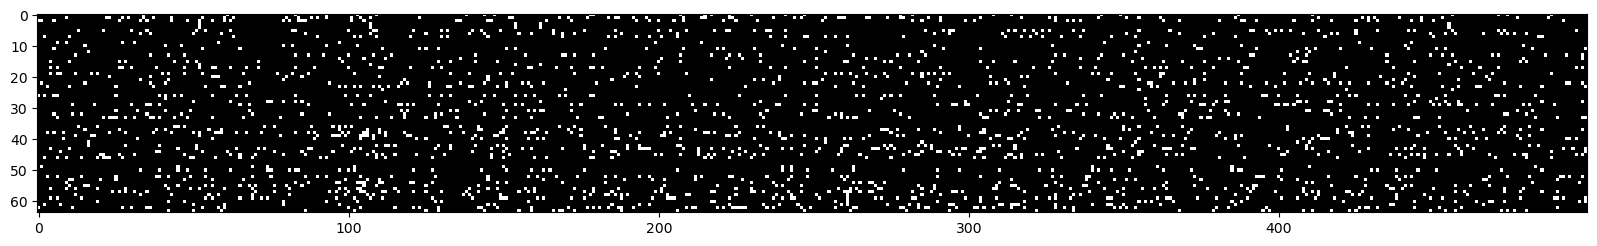

In [82]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

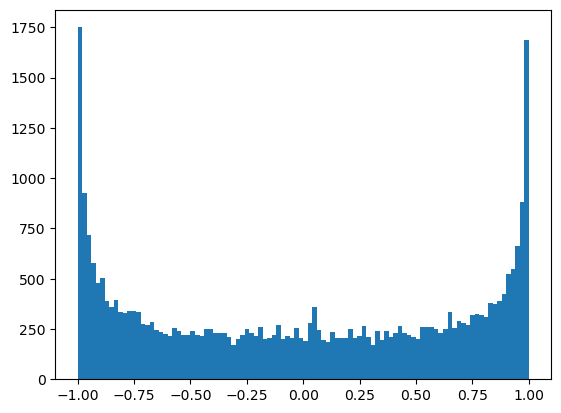

In [83]:
plt.hist(h.view(-1).tolist(), 100);

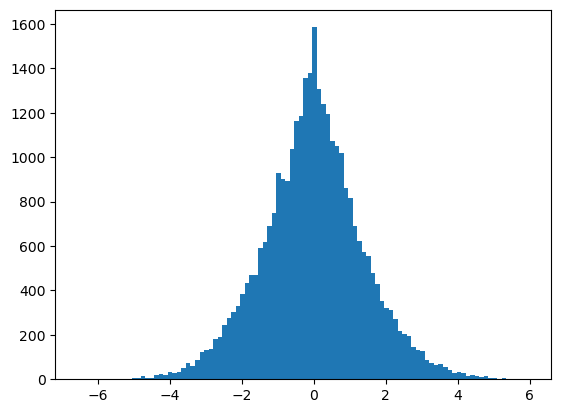

In [84]:
plt.hist(hpreact.view(-1).tolist(), 100);

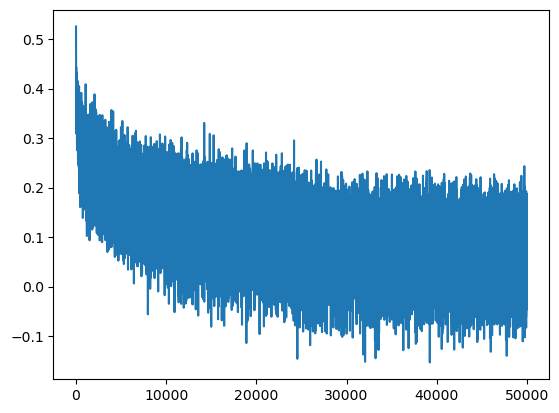

In [85]:
plt.plot(losses)

In [87]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.1560412645339966
val 1.7716666460037231


In [95]:
num_of_names = 5
# Sample from the model
random_seed = int(time.time() * 1000) % (2**32)  # Ограничавамо на 32-битни опсег
g = torch.Generator().manual_seed(random_seed)

for _ in range(num_of_names):
    out = []
    context = [0] * block_size  # Initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 # + b1
        #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)

    # Rekonstruiši ime i promeni prvo slovo u veliko
    name = ''.join(itos[i] for i in out)
    name = name.capitalize()  # Pretvori prvo slovo u veliko

    print(name)

Борета
Рајимир
Бурач
Дражимир
Цветомир
